In [20]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [21]:
import nltk
from nltk.corpus import wordnet
import random

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    if word in synonyms:
        synonyms.remove(word)  # Remove the original word from synonyms
    return list(synonyms)

def synonym_replacement(sentence, n):
    words = nltk.word_tokenize(sentence)
    replaced_sentence = words[:]
    words_indexes = list(range(len(words)))
    random.shuffle(words_indexes)
    
    replaced = 0
    for i in words_indexes:
        synonyms = get_synonyms(words[i])
        if synonyms:
            synonym = random.choice(synonyms)
            replaced_sentence[i] = synonym
            replaced += 1
            if replaced >= n:  # Replace up to n words
                break

    return ' '.join(replaced_sentence)

# Example usage
sentence = "The quick brown fox jumps over the lazy dog"
replaced_sentence = synonym_replacement(sentence, 3)  # Replace up to 3 words
print("Original sentence:", sentence)
print("Sentence after synonym replacement:", replaced_sentence)

Original sentence: The quick brown fox jumps over the lazy dog
Sentence after synonym replacement: The quick brown throw jump-start over the lazy dog-iron


[nltk_data] Downloading package wordnet to /home/raaif/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/raaif/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/raaif/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
from transformers import MarianMTModel, MarianTokenizer

def back_translate(text, model_name_src_to_tgt, model_name_tgt_to_src):
    # Initialize the tokenizer and model for source to target language
    tokenizer_src_to_tgt = MarianTokenizer.from_pretrained(model_name_src_to_tgt)
    model_src_to_tgt = MarianMTModel.from_pretrained(model_name_src_to_tgt)
    
    # Translate from source to target language
    translated = model_src_to_tgt.generate(**tokenizer_src_to_tgt(text, return_tensors="pt", padding=True))
    
    # Decode the translated text
    tgt_text = tokenizer_src_to_tgt.decode(translated[0], skip_special_tokens=True)
    
    # Initialize the tokenizer and model for target to source language
    tokenizer_tgt_to_src = MarianTokenizer.from_pretrained(model_name_tgt_to_src)
    model_tgt_to_src = MarianMTModel.from_pretrained(model_name_tgt_to_src)
    
    # Translate back from target to source language
    back_translated = model_tgt_to_src.generate(**tokenizer_tgt_to_src(tgt_text, return_tensors="pt", padding=True))
    
    # Decode the back-translated text
    src_text = tokenizer_tgt_to_src.decode(back_translated[0], skip_special_tokens=True)
    
    return src_text

# Example usage
text = "The quick brown fox jumps over the lazy dog"
text2 = "A hungry man wants to eat a pizza from the local takeaway"
model_name_src_to_tgt = "Helsinki-NLP/opus-mt-en-fr"
model_name_tgt_to_src = "Helsinki-NLP/opus-mt-fr-en"

back_translated_text = back_translate(text2, model_name_src_to_tgt, model_name_tgt_to_src)
print("Original text:", text2)
print("Back-translated text:", back_translated_text)

/home/raaif/.local/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Original text: A hungry man wants to eat a pizza from the local takeaway
Back-translated text: A hungry man wants to eat a pizza from the corner to take away


In [23]:
import random
import string

def inject_noise(sentence, noise_type='all', noise_level=0.1):
    """
    Injects noise into a given sentence. The type of noise can be specified.
    - sentence: The input sentence to which noise will be added.
    - noise_type: The type of noise to add ('insert', 'delete', 'substitute', or 'all').
    - noise_level: Fraction of characters to alter (between 0 and 1).
    """
    # Function to insert noise: Randomly adds a character within a word
    def insert_noise(word):
        if len(word) > 1:  # Avoid inserting into very short words
            insert_pos = random.randint(1, len(word)-1)  # Avoid inserting at the first position
            insert_char = random.choice(string.ascii_lowercase)
            return word[:insert_pos] + insert_char + word[insert_pos:]
        return word

    # Function to delete noise: Randomly removes a character from a word
    def delete_noise(word):
        if len(word) > 1:
            delete_pos = random.randint(0, len(word)-1)
            return word[:delete_pos] + word[delete_pos+1:]
        return word

    # Function to substitute noise: Replaces a character with a random character
    def substitute_noise(word):
        if len(word) > 1:
            substitute_pos = random.randint(0, len(word)-1)
            substitute_char = random.choice(string.ascii_lowercase)
            return word[:substitute_pos] + substitute_char + word[substitute_pos+1:]
        return word

    noise_functions = {
        'insert': insert_noise,
        'delete': delete_noise,
        'substitute': substitute_noise
    }

    words = sentence.split()
    num_words_to_change = max(1, int(len(words) * noise_level))  # Ensure at least one word is changed
    words_to_change = random.sample(words, num_words_to_change)

    for i, word in enumerate(words):
        if word in words_to_change:
            if noise_type == 'all':
                # Apply a random noise function
                noise_func = random.choice(list(noise_functions.values()))
                words[i] = noise_func(word)
            else:
                # Apply the specified noise function
                words[i] = noise_functions[noise_type](word)

    return ' '.join(words)

# Example usage
sentence = "The quick brown fox jumps over the lazy dog"
print("Original sentence:", sentence)
print("With insertion noise:", inject_noise(sentence, 'insert'))
print("With deletion noise:", inject_noise(sentence, 'delete'))
print("With substitution noise:", inject_noise(sentence, 'substitute'))
print("With random noise of all types:", inject_noise(sentence, 'all'))

Original sentence: The quick brown fox jumps over the lazy dog
With insertion noise: The quick brown fox jvumps over the lazy dog
With deletion noise: The quick brown fox jumps over the lzy dog
With substitution noise: The quick broww fox jumps over the lazy dog
With random noise of all types: The quick brown fox jujmps over the lazy dog


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch

file_path = "train_data/dontpatronizeme_pcl.tsv"
train_filepath = "dev_data/train_semeval_parids-labels.csv"
dev_filepath = "dev_data/dev_semeval_parids-labels.csv"

df = pd.read_csv(file_path, sep='\t', header=None, names=['id', 'paragraph-id', 'keyword', 'countrycode', "paragraph", "label"])
df_filtered = df[df['paragraph'].notna()]

# labels = [[0,1] if int(x)<=1 else [1,0] for x in df_filtered['label']]

# labels = np.array(labels)

# df_filtered['contains_pcl'] = df_filtered['label'].apply(lambda x: np.array([0,1]) if int(x) <= 1 else np.array([1,0])) # [True, False]

train_df = pd.read_csv(train_filepath)
dev_df = pd.read_csv(dev_filepath)

train_data = df_filtered[df_filtered['id'].isin(train_df['par_id'])]
dev_data = df_filtered[df_filtered['id'].isin(dev_df['par_id'])]

# get indexes of labels 0 and 1
train_data_0 = train_data[train_data['label'] <= 1]
train_data_1 = train_data[train_data['label'] > 1]
# get 10% of the training data indexes
train_data_0_10 = train_data_0.sample(frac=0.1, random_state=42)
train_data_undersampled = pd.concat([train_data_0_10, train_data_1])


train_data_shuffled = shuffle(train_data_undersampled, random_state=42)
dev_data_shuffled = shuffle(dev_data, random_state=42)

X_train = train_data_shuffled['paragraph'].to_numpy()
X_dev = dev_data_shuffled['paragraph'].to_numpy()

y_train = np.array([[0,1] if int(x) <= 1 else [1,0] for x in train_data_shuffled['label']])
y_dev = np.array([[0,1] if int(x) <= 1 else [1,0] for x in dev_data_shuffled['label']])

print(X_train.shape)
print(X_dev.shape)


# X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Split the dataset into training (80%) and validation (20%) sets
# X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

(1552,)
(2093,)


In [25]:
train_data_shuffled

,id,paragraph-id,keyword,countrycode,paragraph,label
10101,10102,@@9917783,disabled,pk,After being hit by a burst of pellets in his f...,4
4142,4143,@@4085227,disabled,us,Another piece mocks corrupt members of the dis...,0
7224,7225,@@23178650,poor-families,za,""" Many of our young people come from poor fami...",0
7801,7802,@@3965285,in-need,ca,Hicks said Brigham 's work helped the RFDA est...,0
3603,3604,@@730231,disabled,in,The CBSE has taken a few steps to eliminate th...,3
...,...,...,...,...,...,...
5038,5039,@@15903988,poor-families,ng,Harvey said that the issue of violence against...,4
7067,7068,@@15219246,poor-families,lk,"On the pretext of "" getting to know how the ot...",3
1216,1217,@@22427932,homeless,ph,""" I suddenly had the urge to look for a Filipi...",4
9302,9303,@@23483683,poor-families,in,""" The villages around our campus are not very ...",3


In [26]:
dev_data_shuffled

,id,paragraph-id,keyword,countrycode,paragraph,label
10056,10057,@@4197415,poor-families,ca,Darte acknowledged cutting back to the Windsor...,0
9650,9651,@@25216962,migrant,bd,UNITED States President Donald Trump has defen...,0
9119,9120,@@22467955,immigrant,ca,Saraswat said most immigrants have unique livi...,0
8504,8505,@@10179731,hopeless,pk,He said some elements were bent upon spreading...,0
1282,1283,@@3208839,refugee,ph,""" Stateless "" is the story of a forgotten grou...",4
...,...,...,...,...,...,...
9977,9978,@@13589752,homeless,in,One response to marital infidelity is divorce ...,0
9384,9385,@@1955909,homeless,tz,Various other areas have been experiencing exc...,0
9423,9424,@@18374692,hopeless,ca,Chris Selley : Maybe liquor retail in Ontario ...,0
9594,9595,@@1065878,hopeless,us,Robin Wauters is the European Editor of The Ne...,0


In [27]:
labels = torch.tensor(y_train)
labels

tensor([[1, 0],
        [0, 1],
        [0, 1],
        ...,
        [1, 0],
        [1, 0],
        [1, 0]])

In [28]:
from transformers import RobertaTokenizer

# Load the BERT tokenizer.
print('Loading RoBERTa tokenizer...')
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
'''
Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]
'''

Loading RoBERTa tokenizer...


'\nOriginal:  Our friends won\'t buy this analysis, let alone the next one we propose.\nTokenized:  [\'our\', \'friends\', \'won\', "\'", \'t\', \'buy\', \'this\', \'analysis\', \',\', \'let\', \'alone\', \'the\', \'next\', \'one\', \'we\', \'propose\', \'.\']\nToken IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]\n'

In [29]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable


In [30]:
import wandb

sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'val_f1_score',
      'goal': 'maximize'
    },
    'parameters': {

        'learning_rate': {
            # 'values': [1e-5]
            # 'values': [1e-4, 5e-5, 2.5e-5, 1e-5, 5e-6]
            'values': [1e-6, 5e-6]
        },
        'batch_size': {
            'values': [16]
        },
        'epochs': {
            # 'values': [6, 8, 10]
            'values': [5]
        },
        'warmup_percentage': {
            'values': [0.05]
            # 'values': [0.05, 0.1]
        }
    }
}
sweep_defaults = {
        'learning_rate': 5e-6,

        'batch_size': 16,

        'epochs': 5,

        'warmup_percentage': 0.05
}

sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: kfo3bzg0
Sweep URL: https://wandb.ai/raaif/uncategorized/sweeps/kfo3bzg0


In [31]:
import torch
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in X_train:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 300,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_train)

# Print sentence 0, now as a list of IDs.
print('Original: ', X_train[0])
print('Token IDs:', input_ids[0])
print('Attention Mask:', attention_masks)
print('labels', labels[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/raaif/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  After being hit by a burst of pellets in his face , twenty-year-old Omar Altaf of Islamabad from South Kashmir is disabled forever . He has lost the vision in his left eye while his right eye has faint sight . His blaring eyes are witness to the mayhem he saw on roads when Indian forces fired pellets .
Token IDs: tensor([    0,  4993,   145,   478,    30,    10, 10084,     9, 36529,    11,
           39,   652,  2156, 10328,    12,   180,    12,   279, 11482,  7330,
         2001,     9, 12600,    31,   391,  7525,    16,  6242,  6000,   479,
           91,    34,   685,     5,  3360,    11,    39,   314,  2295,   150,
           39,   235,  2295,    34, 27922,  6112,   479,   832,  3089,  5867,
         2473,    32,  4562,     7,     5, 30524,    37,   794,    15,  3197,
           77,  1362,  1572,  2277, 36529,   479,     2,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1, 

In [32]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, random_split
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, paragraphs, labels, apply_augmentation=False, augmentation_type=None):
        """
        Args:
            paragraphs: Tensor of input ids.
            attention_masks: Tensor of attention masks.
            labels: Tensor of labels.
            apply_augmentation (bool): Flag to control the application of augmentation.
        """
        self.paragraphs = paragraphs
        self.labels = labels
        self.apply_augmentation = apply_augmentation
        self.augmentation_type = augmentation_type

        input_ids = []
        attention_masks = []

        if not apply_augmentation:
          for para in paragraphs:
            encoded_dict = tokenizer.encode_plus(
                        para,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 300,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
            input_ids.append(encoded_dict['input_ids'])
            # Add the encoded sentence to the list.
            input_ids.append(encoded_dict['input_ids'])

            # And its attention mask (simply differentiates padding from non-padding).
            attention_masks.append(encoded_dict['attention_mask'])

          self.input_ids = torch.cat(input_ids, dim=0)
          self.attention_mask = torch.cat(attention_masks, dim=0)



    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        paragraph = self.paragraphs[idx]
        label = self.labels[idx]

        if self.apply_augmentation:
            # Apply data augmentation here
            paragraph = self.augment(paragraph)
        
            encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 300,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )
            input_id = encoded_dict['input_ids'][0]
            attention_mask = encoded_dict['attention_mask'][0]

            return input_id, attention_mask, label
        else:
          return self.input_ids[idx], self.attention_mask[idx], label


    def augment(self, paragraph):
        if self.augmentation_type == 'synonym_replacement':
            # Apply synonym replacement
            paragraph = synonym_replacement(paragraph, 3)
        if self.augmentation_type == 'back_translation':
            # Apply back translation
            paragraph = back_translate(paragraph, model_name_src_to_tgt, model_name_tgt_to_src)
        if self.augmentation_type == 'noise_injection':
            # Apply noise injection
            paragraph = inject_noise(paragraph, 'all', 0.1)
        return paragraph

In [33]:
import torch
train_size = int(0.9 * len(X_train))
val_size = len(X_train) - train_size

# Generate a permutation of indices and then split according to train_size
indices = torch.randperm(len(X_train)).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Use these indices to create the tensors for the training and validation sets
train_input_ids = X_train[train_indices]
train_attention_masks = attention_masks[train_indices]
train_labels = labels[train_indices]

val_input_ids = X_train[val_indices]
val_attention_masks = attention_masks[val_indices]
val_labels = labels[val_indices]

# Now you have split tensors and can create datasets as needed
train_dataset = CustomDataset(train_input_ids, train_labels, apply_augmentation=True, augmentation_type='noise_injection')
val_dataset = CustomDataset(val_input_ids, val_labels, apply_augmentation=False)

In [34]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import wandb
# WANDB PARAMETER
def ret_dataloader():
    batch_size = wandb.config.batch_size
    # batch_size = 16
    print('batch_size = ', batch_size)
    train_dataloader = DataLoader(
                train_dataset,  # The training samples.
                sampler = RandomSampler(train_dataset), # Select batches randomly
                batch_size = batch_size # Trains with this batch size.
            )

    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )
    return train_dataloader,validation_dataloader

In [35]:
# from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import RobertaForSequenceClassification, AdamW, RobertaConfig

def ret_model():

    # model = BertForSequenceClassification.from_pretrained(
    #     "bert-base-uncased",
    #     num_labels = 2,
    #     output_attentions = False, # Whether the model returns attentions weights.
    #     output_hidden_states = False, # Whether the model returns all hidden-states.
    # )
    model = RobertaForSequenceClassification.from_pretrained(
        "roberta-base",
        num_labels = 2,
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    return model

In [36]:
def ret_optim(model):
    print('Learning_rate = ',wandb.config.learning_rate )
    optimizer = AdamW(model.parameters(),
                      lr = wandb.config.learning_rate,
                      eps = 1e-8
                    )
    return optimizer


In [37]:
from transformers import get_linear_schedule_with_warmup

def ret_scheduler(train_dataloader,optimizer):
    epochs = wandb.config.epochs
    print('epochs = ', epochs)
    # Total number of training steps is [number of batches] x [number of epochs].
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs

    wp = wandb.config.warmup_percentage
    print('warmup percentage', wp)
    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps = wp * total_steps,
                                                num_training_steps = total_steps)
    return scheduler

In [38]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
# def flat_accuracy(preds, labels):
#     pred_flat = np.argmax(preds, axis=1).flatten()
#     labels_flat = labels.flatten()
#     return np.sum(pred_flat == labels_flat) / len(labels_flat)


import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [39]:
!pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable


In [40]:
import random
import numpy as np
from torchmetrics import Precision, F1Score, Accuracy
from torch.nn import functional as F
import torch
import gc

# Initialize metrics
# Assuming you're working on a binary classification problem
task = 'binary' # Use 'multiclass' for multi-class classification

# Initialize metrics with the task parameter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# precision = Precision(num_classes=2, average='macro', task=task).to(device)
# f1_score = F1Score(num_classes=2, average='macro', task=task).to(device)
accuracy = Accuracy(num_classes=2, average='macro', task=task).to(device)

    # This training code is based on the `run_glue.py` script here:
    # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

    # Set the seed value all over the place to make this reproducible.
def train():

    wandb.init()
    losses = []
    val_losses = []
    
    # print(device)
    model = ret_model()
    model.to(device)
    #wandb.init(config=sweep_defaults)
    train_dataloader, validation_dataloader = ret_dataloader()
    optimizer = ret_optim(model)
    scheduler = ret_scheduler(train_dataloader,optimizer)
    criterion = torch.nn.BCEWithLogitsLoss()

    #print("config ",wandb.config.learning_rate, "\n",wandb.config)
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    #torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss,
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()
    epochs = wandb.config.epochs
    # For each epoch...
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.
        # precision.reset()
        # f1_score.reset()

        # print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        # print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0
        # total_train_precision = 0
        # total_train_f1 = 0

        # all_train_logits = []
        # all_train_labels = []

        total_TP = 0
        total_FP = 0
        total_FN = 0
        total_TN = 0

        # Put the model into training mode. Don't be mislead--the call to
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader.
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids
            #   [1]: attention masks
            #   [2]: labels
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because
            # accumulating the gradients is "convenient while training RNNs".
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            # print(b_labels)
            # print(b_input_ids)
            # print(b_input_ids.shape)
            outputs = model(b_input_ids,
                                attention_mask=b_input_mask)

            logits = outputs.logits
            # print(logits)
            
            loss = criterion(logits.float(), b_labels.float())
            losses.append(loss.item())
            

            # all_train_logits.append(logits)
            # all_train_labels.append(b_labels)

            predictions = torch.argmax(logits, dim=1).cpu()
            b_labels_vals = np.array([b[0].cpu().numpy() for b in b_labels])

            # print(predictions.shape)
            # print(b_labels_vals.shape)

            TP = ((predictions == 1) & (b_labels_vals == 1)).sum().item()
            FP = ((predictions == 1) & (b_labels_vals == 0)).sum().item()
            FN = ((predictions == 0) & (b_labels_vals == 1)).sum().item()
            TN = ((predictions == 0) & (b_labels_vals == 0)).sum().item()

            total_TP += TP
            total_FP += FP
            total_FN += FN
            total_TN += TN
            
            # Update precision and F1 score
            # print("Logits: ",logits, "Labels:", b_labels)
            
            # precision.update(logits, b_labels)
            # f1_score.update(logits, b_labels)


            # wandb.log(
            #     {'train_batch_loss':loss.item()})
                # 'train_batch_precision': precision.compute().item(),
                # 'train_batch_f1_score': f1_score.compute().item()})
            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value
            # from the tensor.
            total_train_loss += loss.item()
            # total_train_precision += precision.compute().item()
            # total_train_f1 += f1_score.compute().item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # train_logits = torch.cat(all_train_logits, dim=0)
        # train_labels = torch.cat(all_train_labels, dim=0)
        
        # plot losses for each epoch
        plt.plot(losses)
        plt.title('Losses')
        plt.show()

        # precision.update(train_logits, train_labels)
        # f1_score.update(train_logits, train_labels)

        precision = total_TP / (total_TP + total_FP) if total_TP + total_FP > 0 else 0
        recall = total_TP / (total_TP + total_FN) if total_TP + total_FN > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)
        # avg_train_precision = total_train_precision / len(train_dataloader)
        # avg_train_f1 = total_train_f1 / len(train_dataloader)

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        # train_precision = precision.compute().item()
        # train_f1 = f1_score.compute().item()

        wandb.log({'avg_train_loss': avg_train_loss})
        wandb.log({'train_precision': precision})
        wandb.log({'train_f1': f1_score})

        # precision.reset()
        # f1_score.reset()
        accuracy.reset()

        # print("")
        # print("  Average training loss: {0:.2f}".format(avg_train_loss))
        # print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        # print("")
        # print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # total_eval_precision = 0
        # total_eval_f1 = 0

        # all_val_logits = []
        # all_val_labels = []

        total_TP = 0
        total_FP = 0
        total_FN = 0
        total_TN = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            # Unpack this training batch from our dataloader.
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids
            #   [1]: attention masks
            #   [2]: labels
            b_input_ids = batch[0].cuda()
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here:
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                # print("HEREEEEEE")
                # print(b_input_ids.shape)
                
                outputs = model(b_input_ids,
                                      attention_mask=b_input_mask)
            
            logits = outputs.logits

            # print(logits.shape)
            # print(b_labels.shape)
            
            loss = criterion(logits.float(), b_labels.float())

            predictions = torch.argmax(logits, dim=1).cpu()
            b_labels_vals = np.array([b[0].cpu().numpy() for b in b_labels])

            # print(predictions.shape)
            # print(b_labels_vals.shape)

            TP = ((predictions == 1) & (b_labels_vals == 1)).sum().item()
            FP = ((predictions == 1) & (b_labels_vals == 0)).sum().item()
            FN = ((predictions == 0) & (b_labels_vals == 1)).sum().item()
            TN = ((predictions == 0) & (b_labels_vals == 0)).sum().item()

            total_TP += TP
            total_FP += FP
            total_FN += FN
            total_TN += TN

            # all_val_logits.append(logits)
            # all_val_labels.append(b_labels)

            # print("got validation loss without throwing a fit")

            # precision.update(logits, b_labels)
            # f1_score.update(logits, b_labels)
            accuracy.update(logits, b_labels)

            # Accumulate the validation loss.
            total_eval_loss += loss.item()
            
            # total_eval_precision += precision.compute().item()
            # total_eval_f1 += f1_score.compute().item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += accuracy.compute().item()


        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        # print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        val_losses.append(avg_val_loss)
        # avg_val_precision = total_eval_precision / len(validation_dataloader)
        # avg_val_f1 = total_eval_f1 / len(validation_dataloader)

        # val_logits = torch.cat(all_val_logits, dim=0)
        # val_labels = torch.cat(all_val_labels, dim=0)

        # accuracy.update(val_logits, val_labels)
        # precision.update(val_logits, val_labels)
        # f1_score.update(val_logits, val_labels)

        # val_accuracy = accuracy.compute().item()
        # val_precision = precision.compute().item()
        # val_f1 = f1_score.compute().item()

        precision = total_TP / (total_TP + total_FP) if total_TP + total_FP > 0 else 0
        recall = total_TP / (total_TP + total_FN) if total_TP + total_FN > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        wandb.log({'val_accuracy': avg_val_accuracy, 
                   'avg_val_loss': avg_val_loss, 
                   'val_precision': precision, 
                   'val_f1': f1_score})
        # print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        # print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Valid. F1': f1_score,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    # print("")
    print("Training complete!")

    torch.cuda.empty_cache()

    # Call the garbage collector
    gc.collect()
    
    # Ensure CUDA is aware of the freed memory
    torch.cuda.empty_cache()

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    
    # plot validation losses for each epoch
    plt.plot(val_losses)
    plt.title('Validation Losses')
    plt.show()
    
    # plot training losses
    plt.plot(losses)
    plt.title('Training Losses')
    plt.show()

wandb: Agent Starting Run: o3a1a0vq with config:
wandb: 	batch_size: 4
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	warmup_percentage: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/raaif/.local/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/raaif/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad t

batch_size =  4
Learning_rate =  1e-05
epochs =  5
warmup percentage 0.05
======== Epoch 1 / 5 ========
  Batch    40  of    349.    Elapsed: 0:00:04.
  Batch    80  of    349.    Elapsed: 0:00:07.
  Batch   120  of    349.    Elapsed: 0:00:11.
  Batch   160  of    349.    Elapsed: 0:00:15.
  Batch   200  of    349.    Elapsed: 0:00:18.
  Batch   240  of    349.    Elapsed: 0:00:22.
  Batch   280  of    349.    Elapsed: 0:00:26.
  Batch   320  of    349.    Elapsed: 0:00:29.


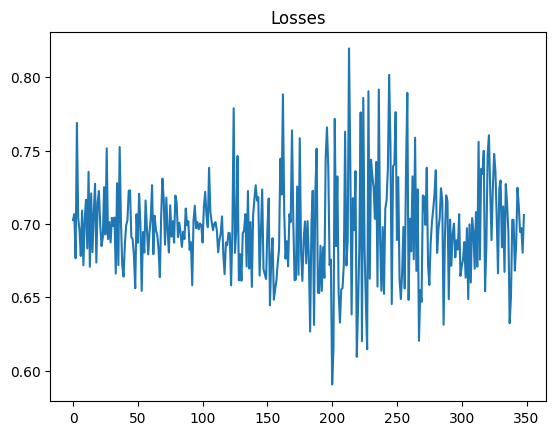

======== Epoch 2 / 5 ========
  Batch    40  of    349.    Elapsed: 0:00:04.
  Batch    80  of    349.    Elapsed: 0:00:07.
  Batch   120  of    349.    Elapsed: 0:00:11.
  Batch   160  of    349.    Elapsed: 0:00:15.
  Batch   200  of    349.    Elapsed: 0:00:18.
  Batch   240  of    349.    Elapsed: 0:00:22.
  Batch   280  of    349.    Elapsed: 0:00:26.
  Batch   320  of    349.    Elapsed: 0:00:29.


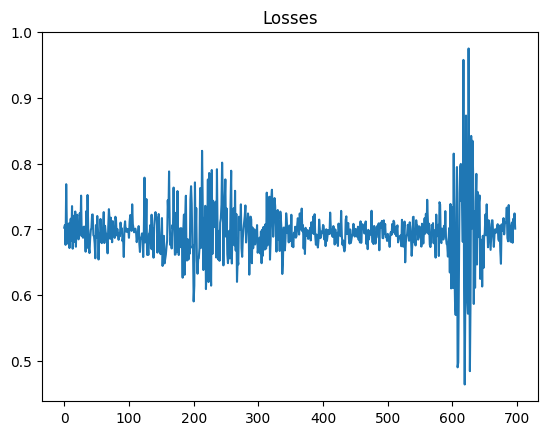

======== Epoch 3 / 5 ========
  Batch    40  of    349.    Elapsed: 0:00:04.
  Batch    80  of    349.    Elapsed: 0:00:07.
  Batch   120  of    349.    Elapsed: 0:00:11.
  Batch   160  of    349.    Elapsed: 0:00:15.
  Batch   200  of    349.    Elapsed: 0:00:18.
  Batch   240  of    349.    Elapsed: 0:00:22.
  Batch   280  of    349.    Elapsed: 0:00:26.
  Batch   320  of    349.    Elapsed: 0:00:29.


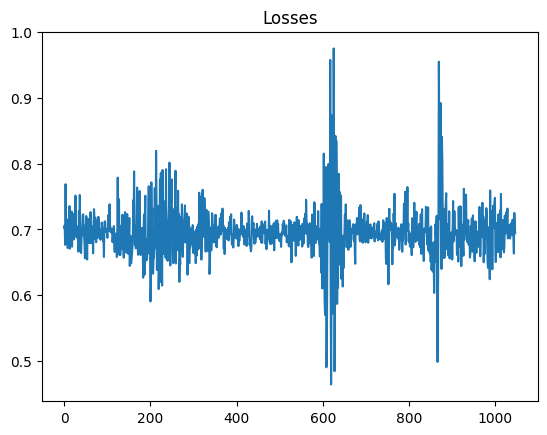

======== Epoch 4 / 5 ========
  Batch    40  of    349.    Elapsed: 0:00:04.
  Batch    80  of    349.    Elapsed: 0:00:07.
  Batch   120  of    349.    Elapsed: 0:00:11.
  Batch   160  of    349.    Elapsed: 0:00:15.
  Batch   200  of    349.    Elapsed: 0:00:18.
  Batch   240  of    349.    Elapsed: 0:00:22.
  Batch   280  of    349.    Elapsed: 0:00:26.
  Batch   320  of    349.    Elapsed: 0:00:29.


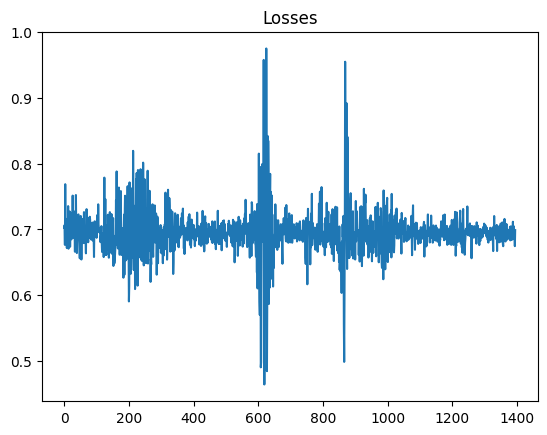

======== Epoch 5 / 5 ========
  Batch    40  of    349.    Elapsed: 0:00:04.
  Batch    80  of    349.    Elapsed: 0:00:07.
  Batch   120  of    349.    Elapsed: 0:00:11.
  Batch   160  of    349.    Elapsed: 0:00:15.
  Batch   200  of    349.    Elapsed: 0:00:18.
  Batch   240  of    349.    Elapsed: 0:00:22.
  Batch   280  of    349.    Elapsed: 0:00:26.
  Batch   320  of    349.    Elapsed: 0:00:29.


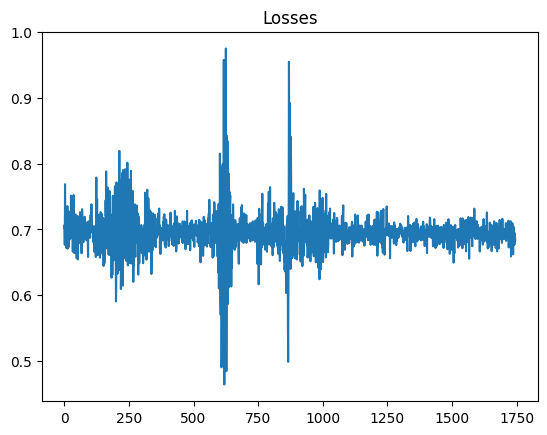

Training complete!
Total training took 0:02:45 (h:mm:ss)


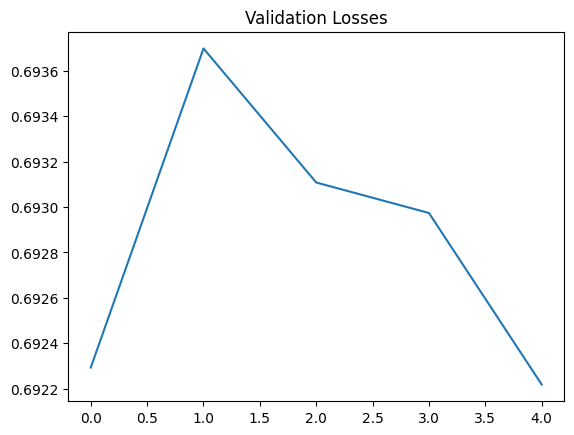

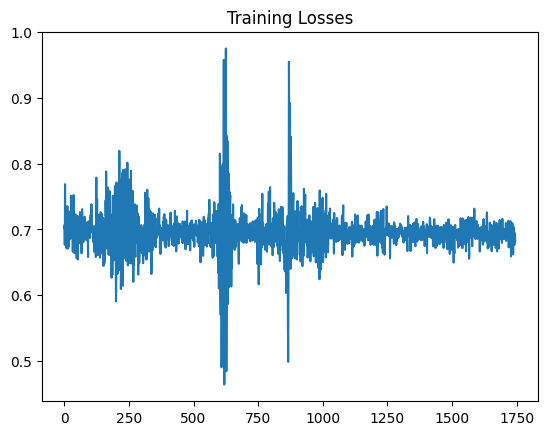

avg_train_loss,█▄▆▄▁
avg_val_loss,▁█▅▅▁
train_f1,▁▇▄██
train_precision,▇▄█▅▁
val_accuracy,▆▁█▅▆
val_f1,▁▁█▁▁
val_precision,▁▁█▁▁
avg_train_loss,0.6931
avg_val_loss,0.69222
train_f1,0.3871
train_precision,0.50917


wandb: Agent Starting Run: 619kbzjk with config:
wandb: 	batch_size: 4
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	warmup_percentage: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/raaif/.local/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/raaif/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad t

batch_size =  4
Learning_rate =  1e-05
epochs =  5
warmup percentage 0.05
======== Epoch 1 / 5 ========
  Batch    40  of    349.    Elapsed: 0:00:04.
  Batch    80  of    349.    Elapsed: 0:00:07.
  Batch   120  of    349.    Elapsed: 0:00:11.
  Batch   160  of    349.    Elapsed: 0:00:15.
  Batch   200  of    349.    Elapsed: 0:00:18.
  Batch   240  of    349.    Elapsed: 0:00:22.
  Batch   280  of    349.    Elapsed: 0:00:26.
  Batch   320  of    349.    Elapsed: 0:00:29.


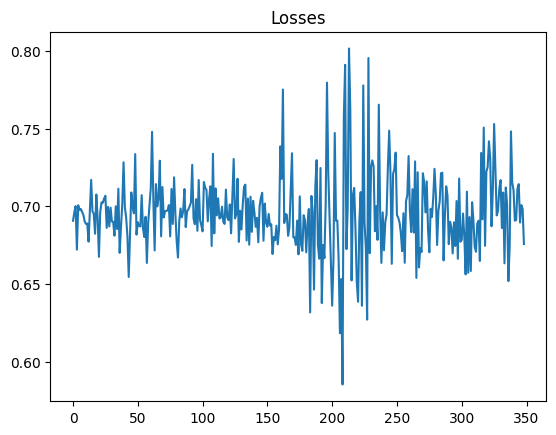

======== Epoch 2 / 5 ========
  Batch    40  of    349.    Elapsed: 0:00:04.
  Batch    80  of    349.    Elapsed: 0:00:07.
  Batch   120  of    349.    Elapsed: 0:00:11.
  Batch   160  of    349.    Elapsed: 0:00:15.
  Batch   200  of    349.    Elapsed: 0:00:18.
  Batch   240  of    349.    Elapsed: 0:00:22.
  Batch   280  of    349.    Elapsed: 0:00:26.
  Batch   320  of    349.    Elapsed: 0:00:29.


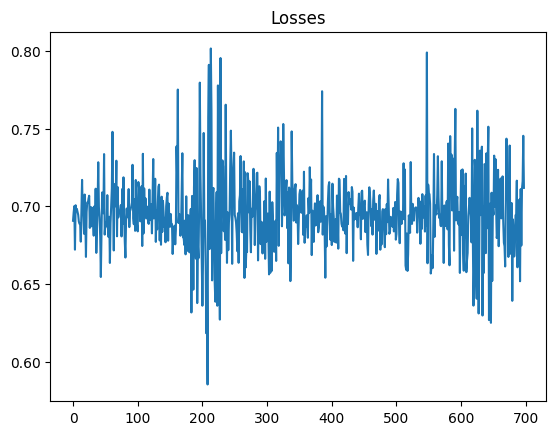

======== Epoch 3 / 5 ========
  Batch    40  of    349.    Elapsed: 0:00:04.
  Batch    80  of    349.    Elapsed: 0:00:07.
  Batch   120  of    349.    Elapsed: 0:00:11.
  Batch   160  of    349.    Elapsed: 0:00:15.
  Batch   200  of    349.    Elapsed: 0:00:18.
  Batch   240  of    349.    Elapsed: 0:00:22.
  Batch   280  of    349.    Elapsed: 0:00:26.
  Batch   320  of    349.    Elapsed: 0:00:29.


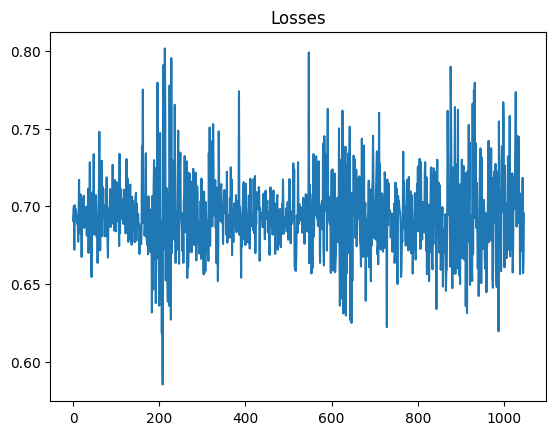

======== Epoch 4 / 5 ========
  Batch    40  of    349.    Elapsed: 0:00:04.
  Batch    80  of    349.    Elapsed: 0:00:07.
  Batch   120  of    349.    Elapsed: 0:00:11.
  Batch   160  of    349.    Elapsed: 0:00:15.
  Batch   200  of    349.    Elapsed: 0:00:18.
  Batch   240  of    349.    Elapsed: 0:00:22.
  Batch   280  of    349.    Elapsed: 0:00:26.
  Batch   320  of    349.    Elapsed: 0:00:29.


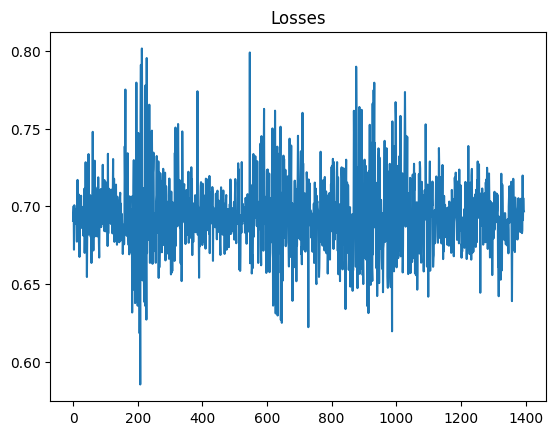

======== Epoch 5 / 5 ========
  Batch    40  of    349.    Elapsed: 0:00:04.
  Batch    80  of    349.    Elapsed: 0:00:07.
  Batch   120  of    349.    Elapsed: 0:00:11.
  Batch   160  of    349.    Elapsed: 0:00:15.
  Batch   200  of    349.    Elapsed: 0:00:18.
  Batch   240  of    349.    Elapsed: 0:00:22.
  Batch   280  of    349.    Elapsed: 0:00:26.
  Batch   320  of    349.    Elapsed: 0:00:29.


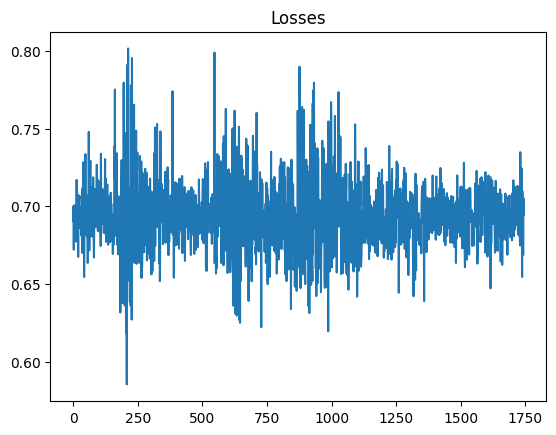

Training complete!
Total training took 0:02:46 (h:mm:ss)


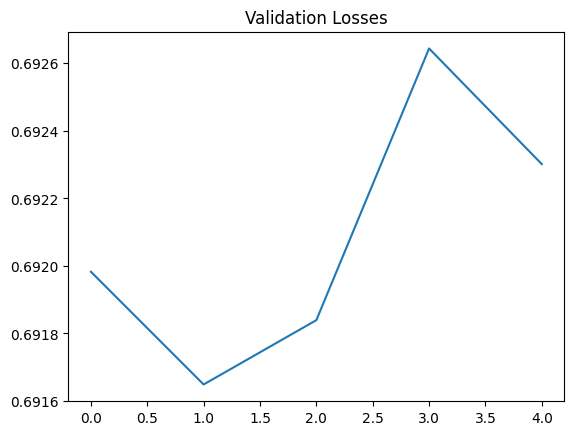

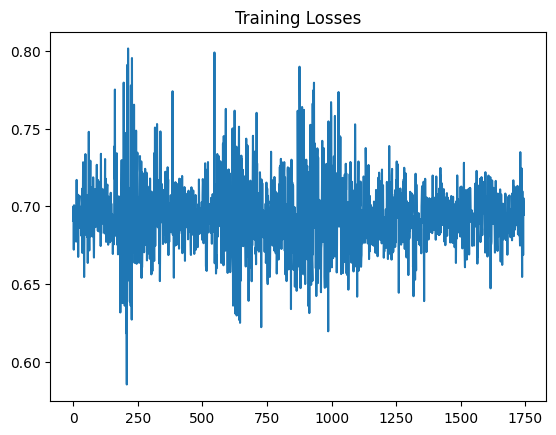

avg_train_loss,█▆▅▁▂
avg_val_loss,▃▁▂█▆
train_f1,█▇▁▂█
train_precision,▅█▁▃▅
val_accuracy,▁████
val_f1,█▁▁▁▁
val_precision,█▁▁▁▁
avg_train_loss,0.69387
avg_val_loss,0.6923
train_f1,0.41075
train_precision,0.53499


wandb: Agent Starting Run: 7vcba23a with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-06
wandb: 	warmup_percentage: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/raaif/.local/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/raaif/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad t

batch_size =  16
Learning_rate =  1e-06
epochs =  5
warmup percentage 0.05
======== Epoch 1 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


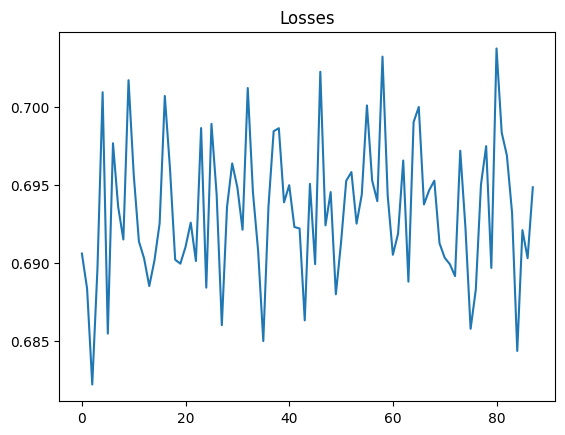

======== Epoch 2 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


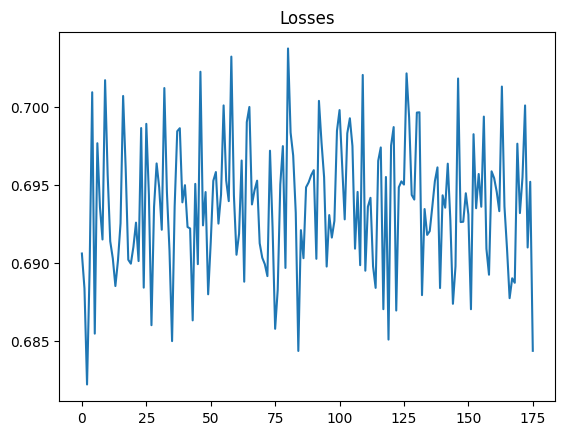

======== Epoch 3 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


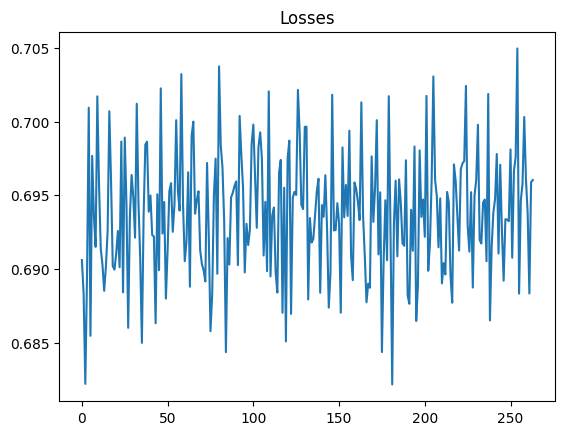

======== Epoch 4 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


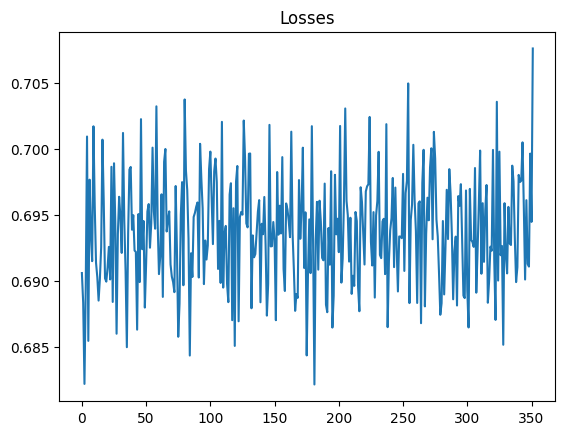

======== Epoch 5 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


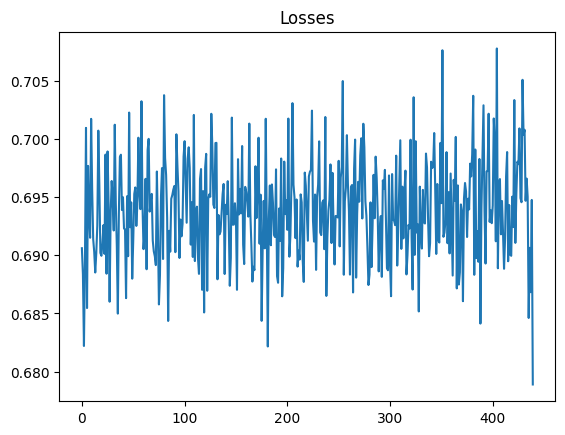

Training complete!
Total training took 0:02:07 (h:mm:ss)


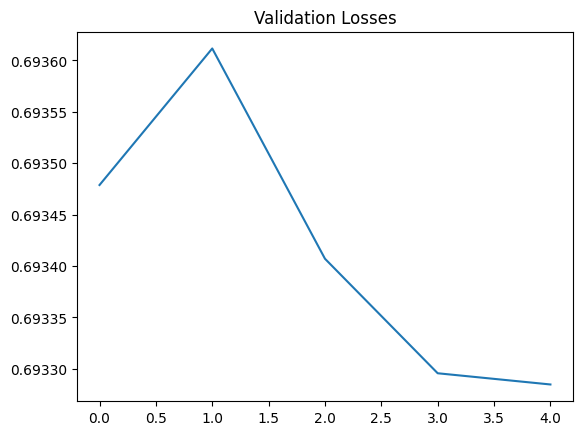

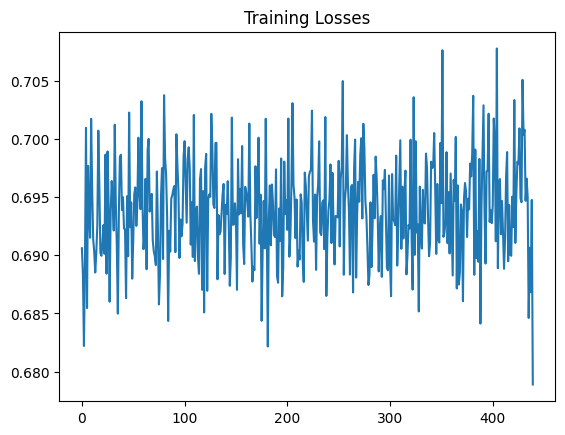

avg_train_loss,▁▆▅▆█
avg_val_loss,▅█▄▁▁
train_f1,██▅▂▁
train_precision,▁▅▅█▂
val_accuracy,█▁▃▁▁
val_f1,▇█▅▁▁
val_precision,▆▁█▆▆
avg_train_loss,0.69431
avg_val_loss,0.69328
train_f1,0.38407
train_precision,0.5179


wandb: Agent Starting Run: ziam53ue with config:
wandb: 	batch_size: 8
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	warmup_percentage: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/raaif/.local/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/raaif/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad t

batch_size =  8
Learning_rate =  1e-05
epochs =  5
warmup percentage 0.05
======== Epoch 1 / 5 ========
  Batch    40  of    175.    Elapsed: 0:00:06.
  Batch    80  of    175.    Elapsed: 0:00:12.
  Batch   120  of    175.    Elapsed: 0:00:19.
  Batch   160  of    175.    Elapsed: 0:00:25.


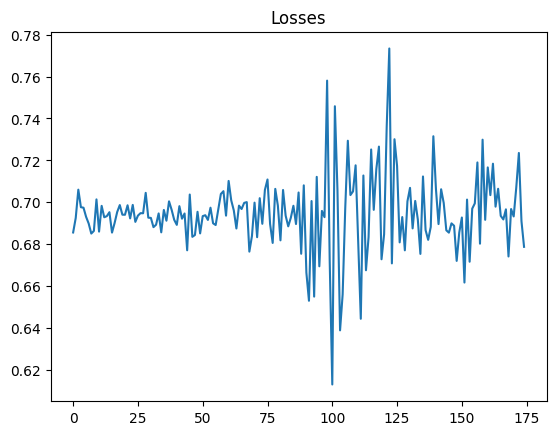

======== Epoch 2 / 5 ========
  Batch    40  of    175.    Elapsed: 0:00:06.
  Batch    80  of    175.    Elapsed: 0:00:12.
  Batch   120  of    175.    Elapsed: 0:00:19.
  Batch   160  of    175.    Elapsed: 0:00:25.


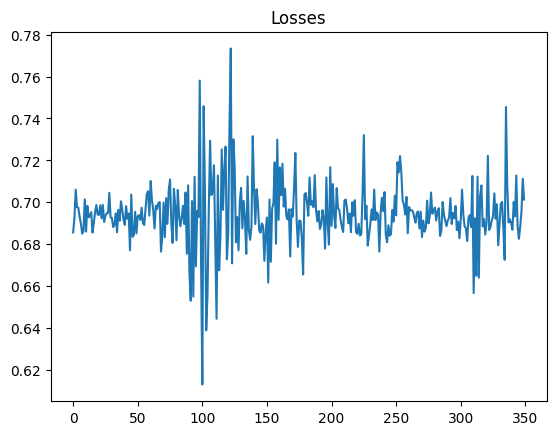

======== Epoch 3 / 5 ========
  Batch    40  of    175.    Elapsed: 0:00:06.
  Batch    80  of    175.    Elapsed: 0:00:12.
  Batch   120  of    175.    Elapsed: 0:00:19.
  Batch   160  of    175.    Elapsed: 0:00:25.


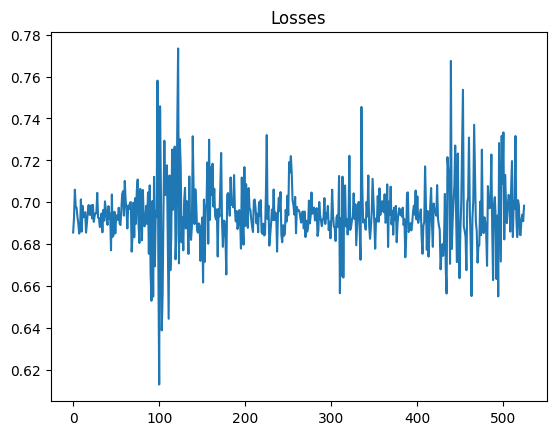

======== Epoch 4 / 5 ========
  Batch    40  of    175.    Elapsed: 0:00:06.
  Batch    80  of    175.    Elapsed: 0:00:12.
  Batch   120  of    175.    Elapsed: 0:00:19.
  Batch   160  of    175.    Elapsed: 0:00:25.


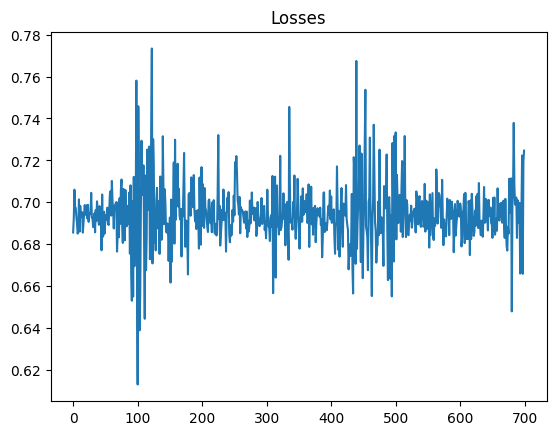

======== Epoch 5 / 5 ========
  Batch    40  of    175.    Elapsed: 0:00:06.
  Batch    80  of    175.    Elapsed: 0:00:12.
  Batch   120  of    175.    Elapsed: 0:00:19.
  Batch   160  of    175.    Elapsed: 0:00:25.


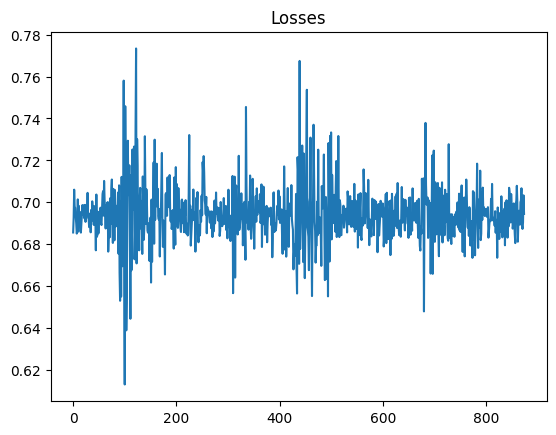

Training complete!
Total training took 0:02:21 (h:mm:ss)


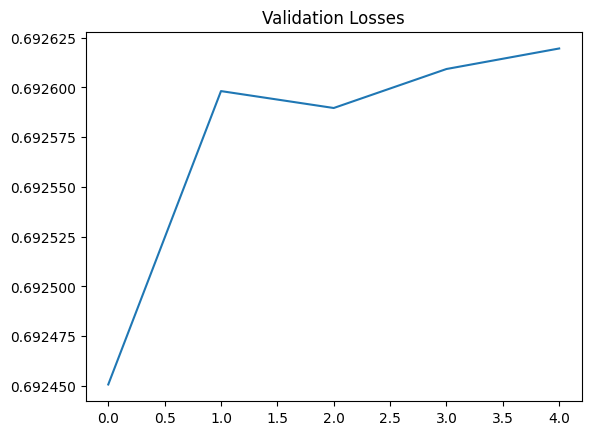

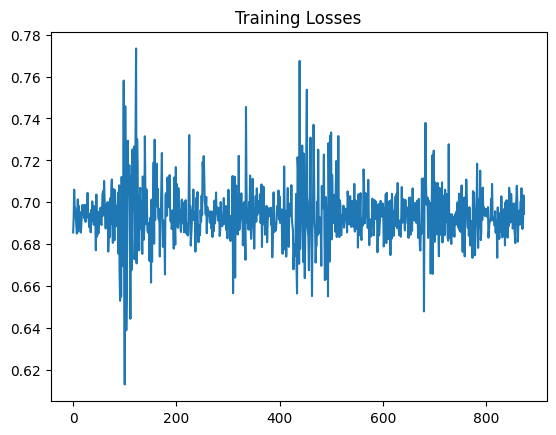

avg_train_loss,█▇█▅▁
avg_val_loss,▁▇▇██
train_f1,▆█▃▃▁
train_precision,▅▇▆█▁
val_accuracy,█▁▄▁▁
val_f1,█▁▁▁▁
val_precision,█▁▁▁▁
avg_train_loss,0.69325
avg_val_loss,0.69262
train_f1,0.18715
train_precision,0.47159


wandb: Agent Starting Run: jmzb0ws4 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	warmup_percentage: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/raaif/.local/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/raaif/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad t

batch_size =  16
Learning_rate =  0.0001
epochs =  5
warmup percentage 0.05
======== Epoch 1 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


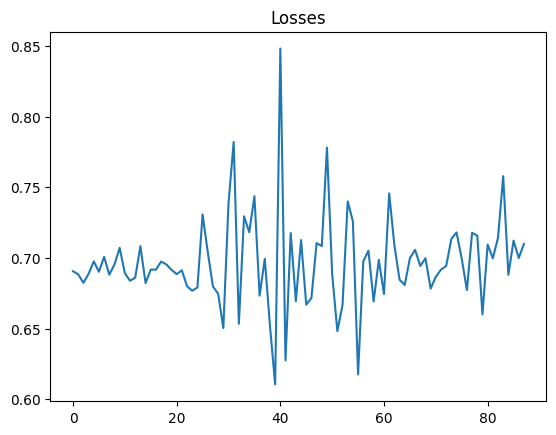

======== Epoch 2 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


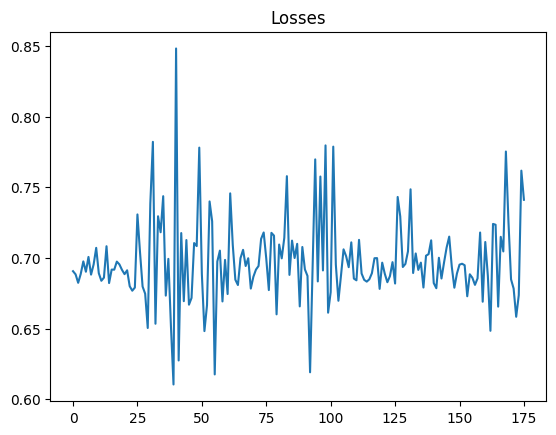

======== Epoch 3 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


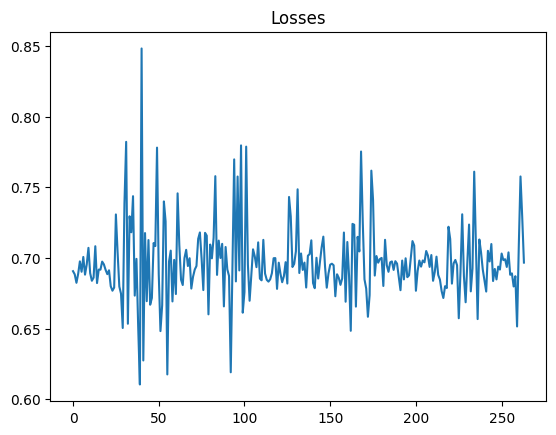

======== Epoch 4 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


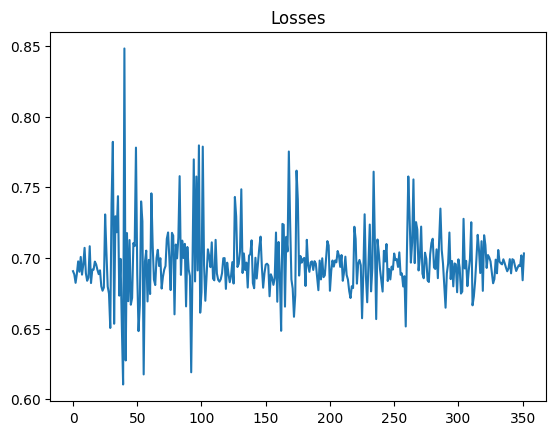

======== Epoch 5 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


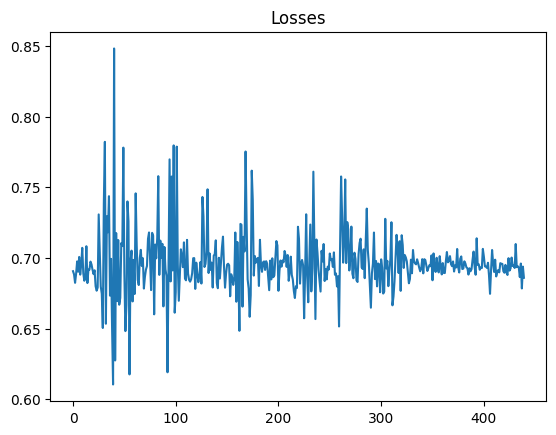

Training complete!
Total training took 0:02:07 (h:mm:ss)


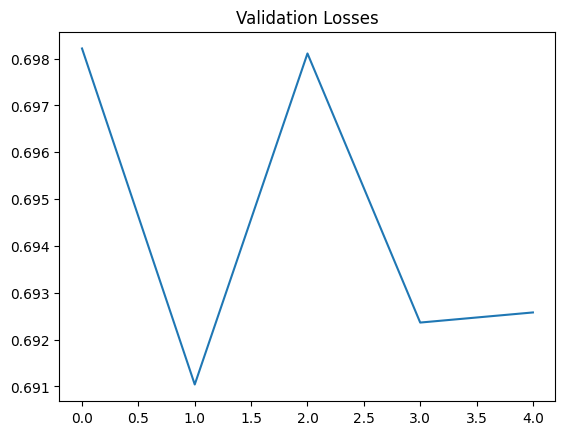

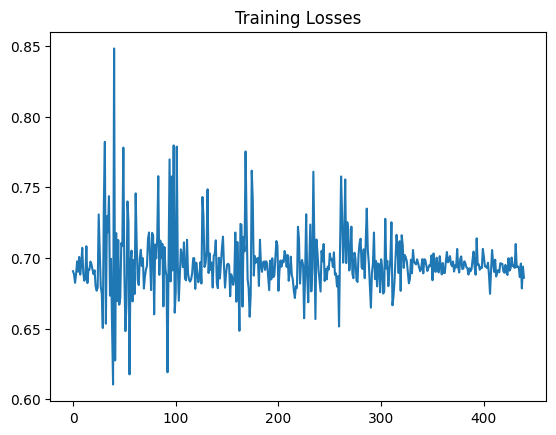

avg_train_loss,▅█▂▆▁
avg_val_loss,█▁█▂▃
train_f1,▇█▄▁▄
train_precision,▁▁▂█▅
val_accuracy,█▁█▁▁
val_f1,█▁█▁▁
val_precision,█▁█▁▁
avg_train_loss,0.69429
avg_val_loss,0.69258
train_f1,0.38165
train_precision,0.54881


wandb: Agent Starting Run: hx5hukgs with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-06
wandb: 	warmup_percentage: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/raaif/.local/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/raaif/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad t

batch_size =  16
Learning_rate =  1e-06
epochs =  5
warmup percentage 0.05
======== Epoch 1 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


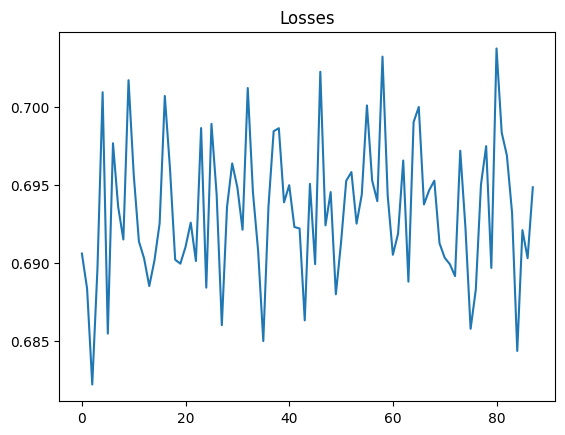

======== Epoch 2 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


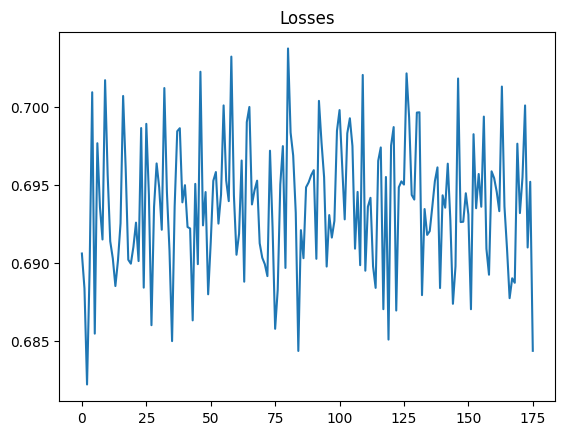

======== Epoch 3 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


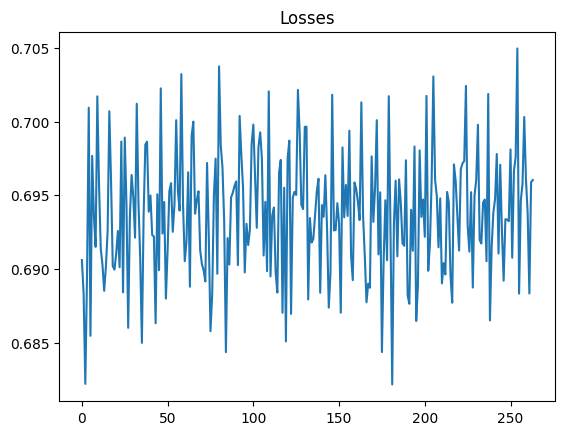

======== Epoch 4 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


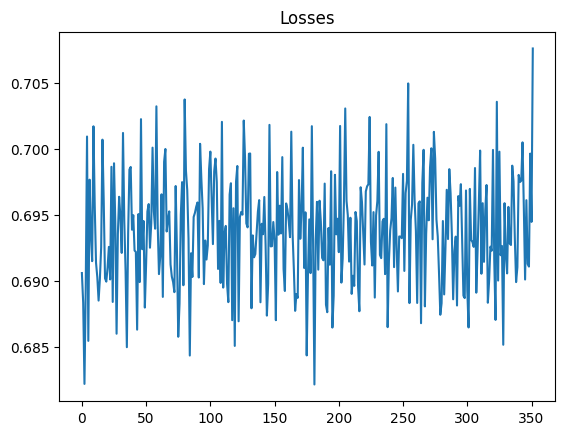

======== Epoch 5 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


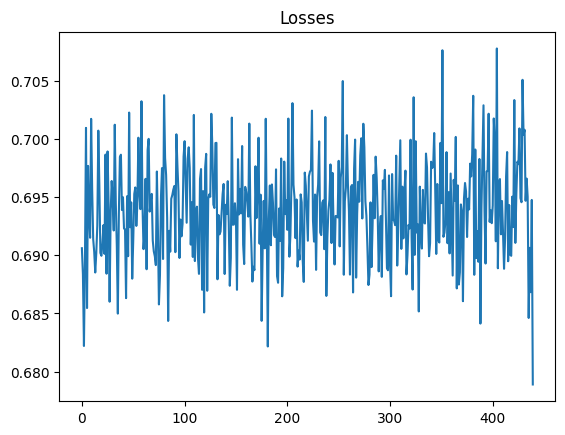

Training complete!
Total training took 0:02:07 (h:mm:ss)


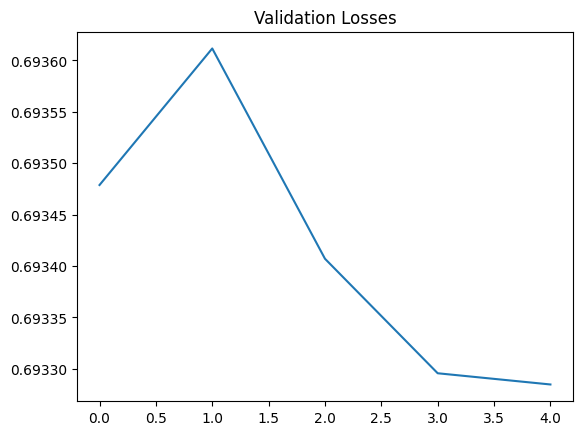

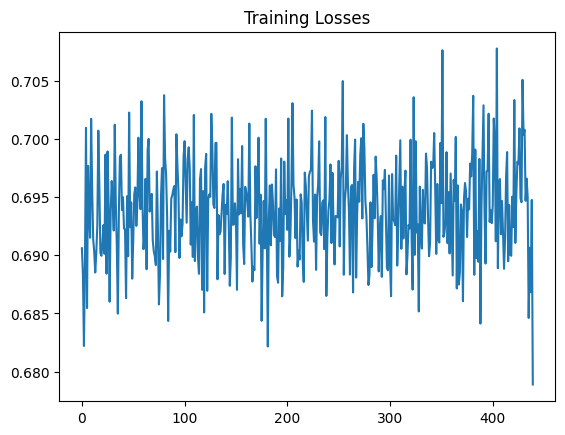

avg_train_loss,▁▆▅▆█
avg_val_loss,▅█▄▁▁
train_f1,██▅▂▁
train_precision,▁▅▅█▂
val_accuracy,█▁▃▁▁
val_f1,▇█▅▁▁
val_precision,▆▁█▆▆
avg_train_loss,0.69431
avg_val_loss,0.69328
train_f1,0.38407
train_precision,0.5179


wandb: Agent Starting Run: xgwmjkd4 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	warmup_percentage: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/raaif/.local/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/raaif/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad t

batch_size =  8
Learning_rate =  0.0001
epochs =  5
warmup percentage 0.05
======== Epoch 1 / 5 ========
  Batch    40  of    175.    Elapsed: 0:00:06.
  Batch    80  of    175.    Elapsed: 0:00:12.
  Batch   120  of    175.    Elapsed: 0:00:19.
  Batch   160  of    175.    Elapsed: 0:00:25.


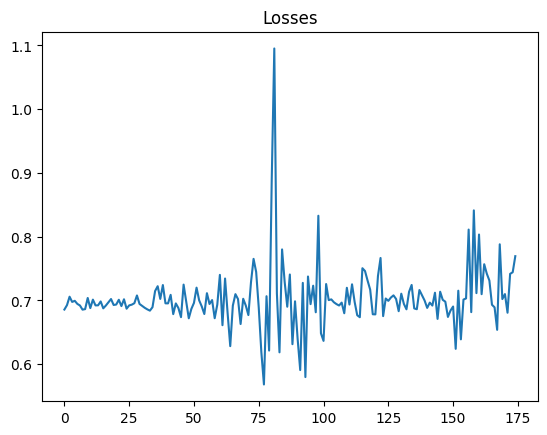

======== Epoch 2 / 5 ========
  Batch    40  of    175.    Elapsed: 0:00:06.
  Batch    80  of    175.    Elapsed: 0:00:12.
  Batch   120  of    175.    Elapsed: 0:00:19.
  Batch   160  of    175.    Elapsed: 0:00:25.


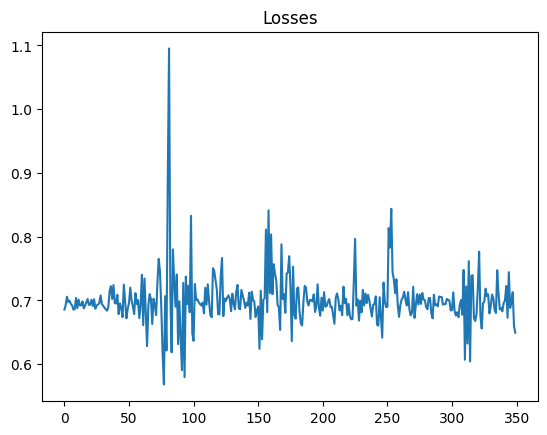

======== Epoch 3 / 5 ========
  Batch    40  of    175.    Elapsed: 0:00:06.
  Batch    80  of    175.    Elapsed: 0:00:12.
  Batch   120  of    175.    Elapsed: 0:00:19.
  Batch   160  of    175.    Elapsed: 0:00:25.


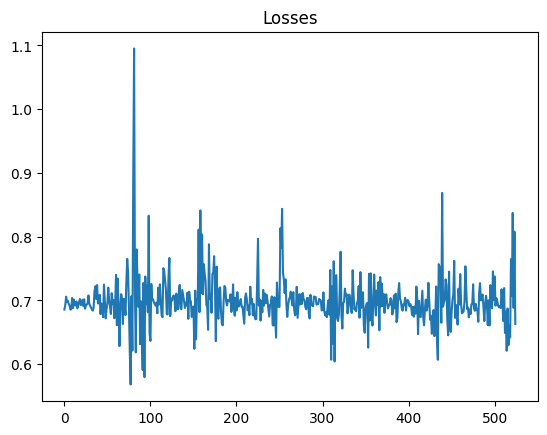

======== Epoch 4 / 5 ========
  Batch    40  of    175.    Elapsed: 0:00:06.
  Batch    80  of    175.    Elapsed: 0:00:12.
  Batch   120  of    175.    Elapsed: 0:00:19.
  Batch   160  of    175.    Elapsed: 0:00:25.


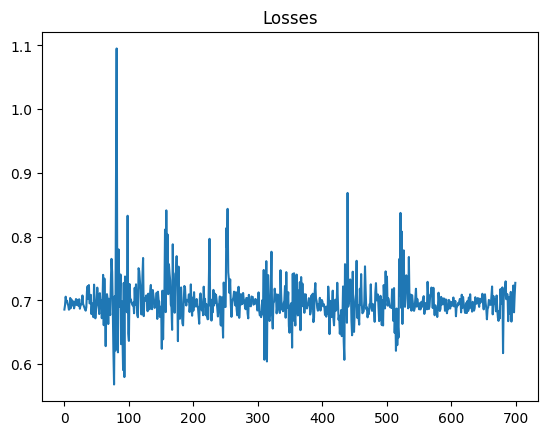

======== Epoch 5 / 5 ========
  Batch    40  of    175.    Elapsed: 0:00:06.
  Batch    80  of    175.    Elapsed: 0:00:12.
  Batch   120  of    175.    Elapsed: 0:00:19.
  Batch   160  of    175.    Elapsed: 0:00:25.


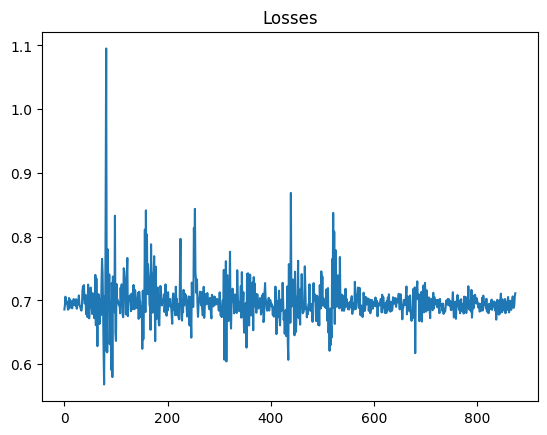

Training complete!
Total training took 0:02:21 (h:mm:ss)


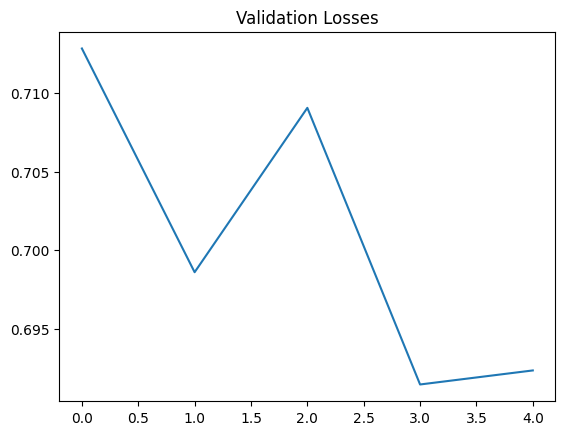

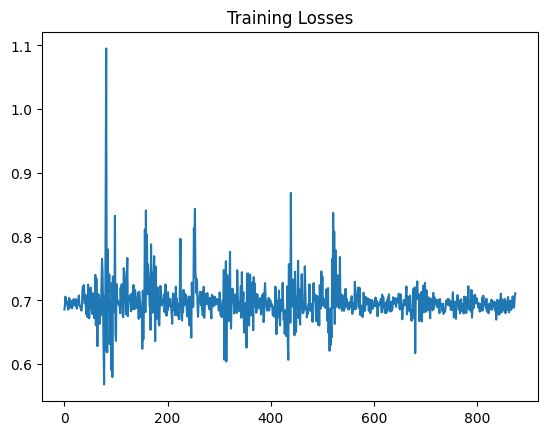

avg_train_loss,█▄▂▄▁
avg_val_loss,█▃▇▁▁
train_f1,██▄▅▁
train_precision,▃▃▁█▁
val_accuracy,███▁▁
val_f1,███▁▁
val_precision,███▁▁
avg_train_loss,0.69345
avg_val_loss,0.69237
train_f1,0.21806
train_precision,0.50254


wandb: Agent Starting Run: r0j8u5yr with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-06
wandb: 	warmup_percentage: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/raaif/.local/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/raaif/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad t

batch_size =  16
Learning_rate =  1e-06
epochs =  5
warmup percentage 0.05
======== Epoch 1 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


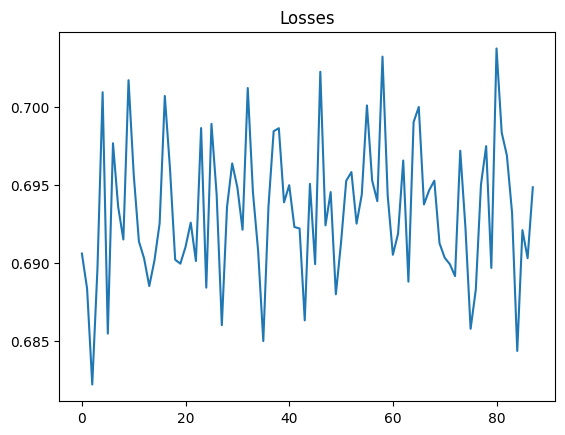

======== Epoch 2 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


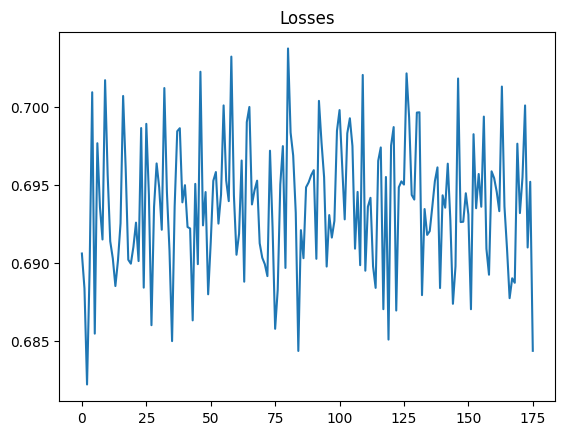

======== Epoch 3 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


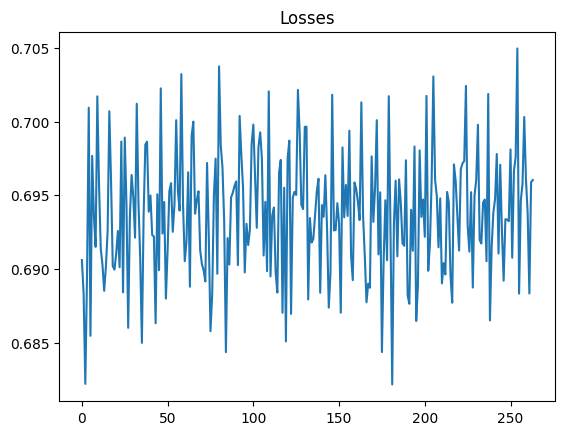

======== Epoch 4 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


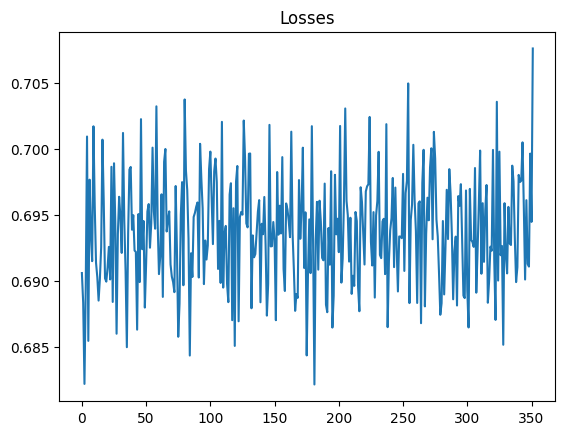

======== Epoch 5 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


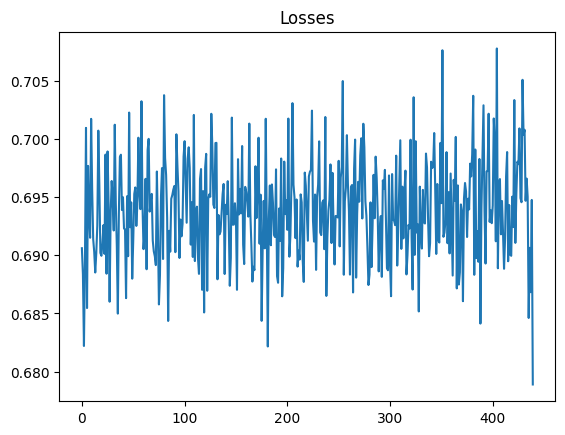

Training complete!
Total training took 0:02:07 (h:mm:ss)


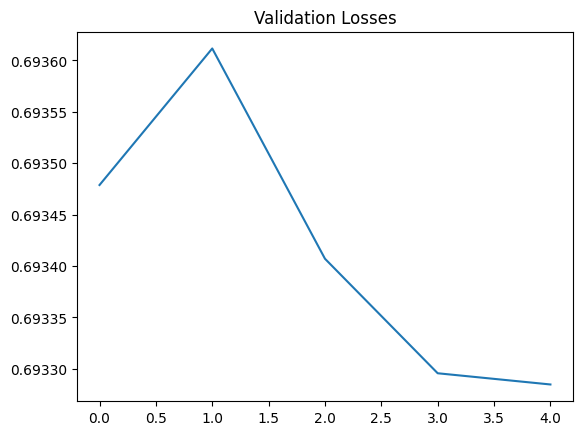

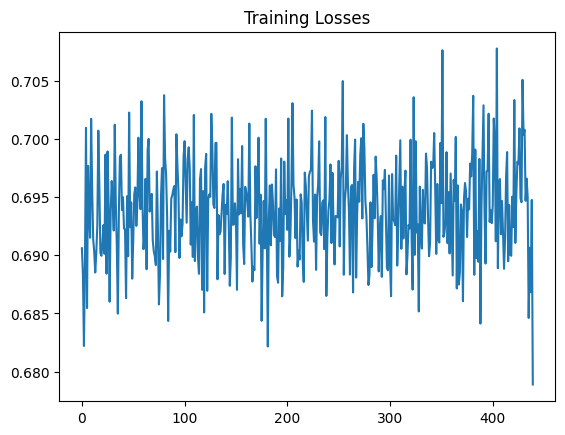

avg_train_loss,▁▆▅▆█
avg_val_loss,▅█▄▁▁
train_f1,██▅▂▁
train_precision,▁▅▅█▂
val_accuracy,█▁▃▁▁
val_f1,▇█▅▁▁
val_precision,▆▁█▆▆
avg_train_loss,0.69431
avg_val_loss,0.69328
train_f1,0.38407
train_precision,0.5179


wandb: Agent Starting Run: rmwdnhgu with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	warmup_percentage: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/raaif/.local/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/raaif/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad t

batch_size =  16
Learning_rate =  0.0001
epochs =  5
warmup percentage 0.05
======== Epoch 1 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


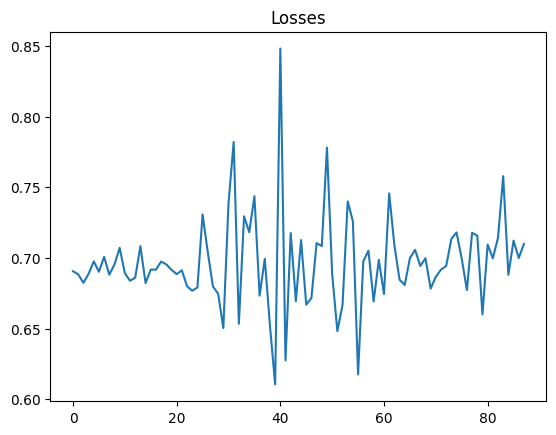

======== Epoch 2 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


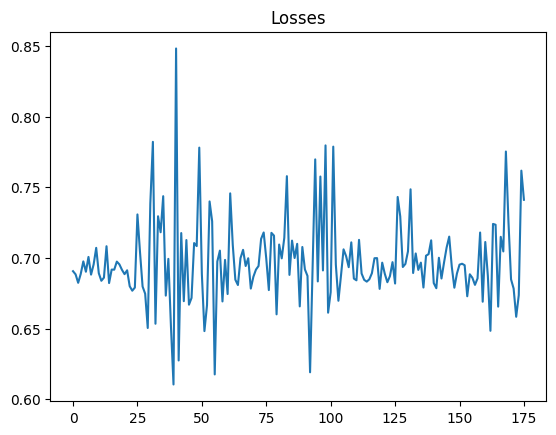

======== Epoch 3 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


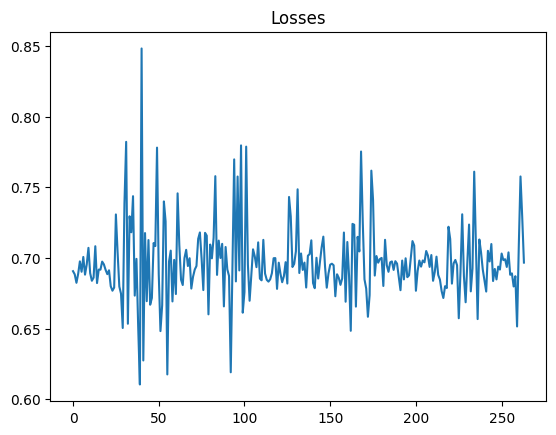

======== Epoch 4 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


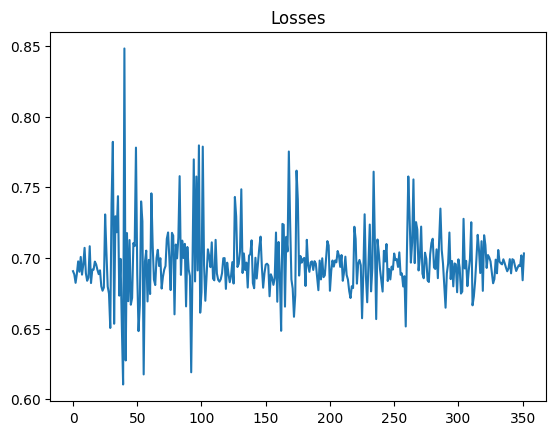

======== Epoch 5 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


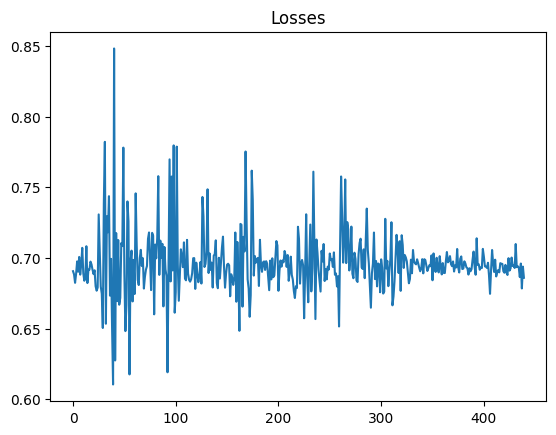

Training complete!
Total training took 0:02:07 (h:mm:ss)


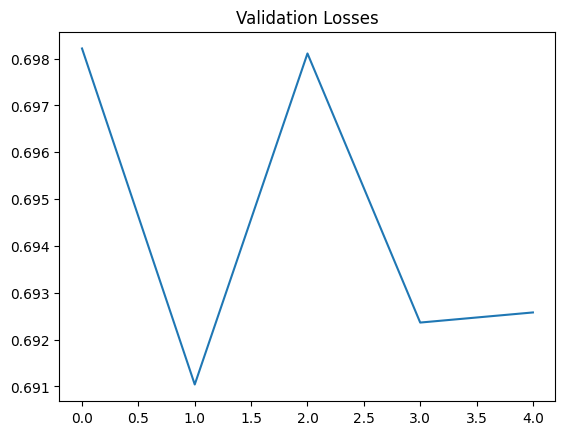

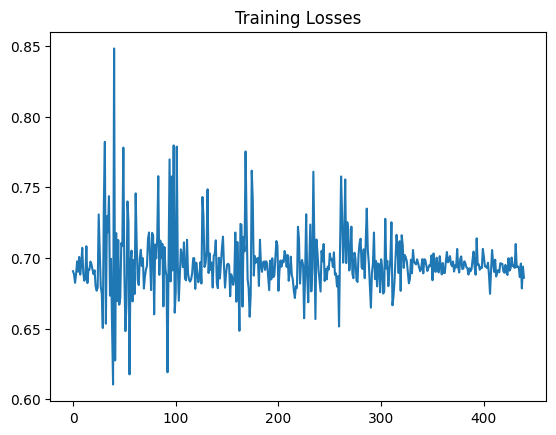

avg_train_loss,▅█▂▆▁
avg_val_loss,█▁█▂▃
train_f1,▇█▄▁▄
train_precision,▁▁▂█▅
val_accuracy,█▁█▁▁
val_f1,█▁█▁▁
val_precision,█▁█▁▁
avg_train_loss,0.69429
avg_val_loss,0.69258
train_f1,0.38165
train_precision,0.54881


wandb: Agent Starting Run: s9ryqlwb with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-06
wandb: 	warmup_percentage: 0.05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/raaif/.local/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/raaif/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad t

batch_size =  16
Learning_rate =  1e-06
epochs =  5
warmup percentage 0.05
======== Epoch 1 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.
  Batch    80  of     88.    Elapsed: 0:00:22.


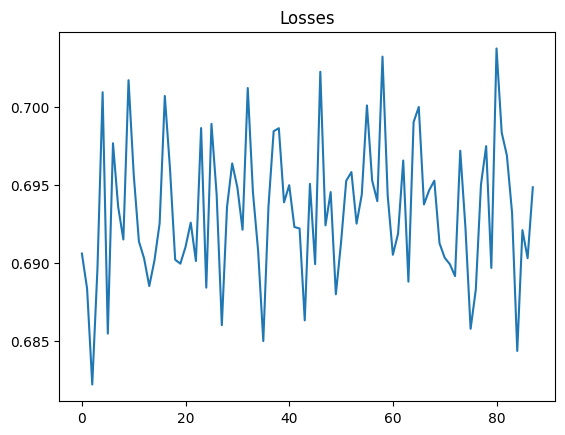

======== Epoch 2 / 5 ========
  Batch    40  of     88.    Elapsed: 0:00:11.


wandb: Ctrl + C detected. Stopping sweep.


  Batch    80  of     88.    Elapsed: 0:00:22.


In [41]:
wandb.agent(sweep_id,function=train)

In [1]:
import torch
import gc

torch.cuda.empty_cache()

# Call the garbage collector
gc.collect()

# Ensure CUDA is aware of the freed memory
torch.cuda.empty_cache()


In [76]:
labels[:32].unsqueeze(0).view(-1).shape

torch.Size([64])